# Cluster POIs using HDBSCAN

In [35]:
import pandas as pd
from geopandas import GeoDataFrame
import numpy as np
from time import time
import shapely as shp
import folium
import hdbscan

In [36]:
input_dir = '../data/input/'
output_dir = '../data/output/'

## Read input file

In [37]:
pois = pd.read_pickle(input_dir + 'london_pois_gdf.pkl')
print("POIs loaded: %s" % (len(pois.index)))
pois.head()

POIs loaded: 85187


,poi_id,poi_name,poi_kwds,geometry
0,N10287073,Wembley Central,"[transport, station]",POINT (518206.2277696228 185095.8309513291)
1,N10370938,Hadley Wood,"[transport, station]",POINT (526215.3641507154 198221.9922744819)
2,N10371887,Alexandra Palace,"[transport, station]",POINT (530280.7522176408 190456.0047157237)
3,N10606316,St John Street / Goswell Road,"[transport, busstop]",POINT (531464.3598053379 183078.4395275304)
4,N10713594,Carshalton Beeches,"[transport, station]",POINT (527562.7459662389 163605.7092331609)


## Optionally filter POIs by keywords

In [38]:
#kwd_filter = set(['food'])
kwd_filter = set([])

In [39]:
pois = pois[pois['poi_kwds'].map(lambda x: bool(kwd_filter & set(x)) if len(kwd_filter) > 0 else True)]
print("POIs filtered: %s" % (len(pois.index)))
pois.head()

POIs filtered: 85187


,poi_id,poi_name,poi_kwds,geometry
0,N10287073,Wembley Central,"[transport, station]",POINT (518206.2277696228 185095.8309513291)
1,N10370938,Hadley Wood,"[transport, station]",POINT (526215.3641507154 198221.9922744819)
2,N10371887,Alexandra Palace,"[transport, station]",POINT (530280.7522176408 190456.0047157237)
3,N10606316,St John Street / Goswell Road,"[transport, busstop]",POINT (531464.3598053379 183078.4395275304)
4,N10713594,Carshalton Beeches,"[transport, station]",POINT (527562.7459662389 163605.7092331609)


## Prepare coordinates for clustering

In [40]:
pois["lon"] = pois['geometry'].map(lambda p: p.x)
pois["lat"] = pois['geometry'].map(lambda p: p.y)
coords = pois[['lon', 'lat']].values
pois = pois.drop(columns=['lon', 'lat'])
print(coords)
print('\nArray size %s' % len(coords))

[[518206.22776962 185095.83095133]
 [526215.36415072 198221.99227448]
 [530280.75221764 190456.00471572]
 ...
 [529878.71872102 181102.24560607]
 [530185.45061735 181210.6322924 ]
 [533977.14911837 176219.48300751]]

Array size 85187


## Set HDBSCAN parameters minPts

In [41]:
minPts = 50

## Run HDBSCAN

In [42]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=minPts)
t0 = time()
labels = clusterer.fit_predict(coords)
print("Done in %0.3fs." % (time() - t0))
num_clusters = len(set(labels))
print('Number of clusters: %d' % num_clusters)

/home/user/miniconda3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:334: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/user/miniconda3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:334: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/user/miniconda3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:334: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/user/miniconda3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:334: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)


Done in 5.512s.
Number of clusters: 230


## Add cluster labels to initial POIs

In [43]:
pois['label'] = labels
clustered_pois = pois[pois.label > -1]
clustered_pois.head(20)

,poi_id,poi_name,poi_kwds,geometry,label
0,N10287073,Wembley Central,"[transport, station]",POINT (518206.2277696228 185095.8309513291),64
3,N10606316,St John Street / Goswell Road,"[transport, busstop]",POINT (531464.3598053379 183078.4395275304),204
6,N11248823,Selhurst,"[transport, station]",POINT (533084.5780242808 167646.1388046202),38
7,N11248832,Thornton Heath,"[transport, station]",POINT (532252.1864341878 168358.7221607692),38
11,N11249226,Norwood Junction,"[transport, station]",POINT (534041.1170290327 168216.218479352),38
12,N11249237,Forest Hill,"[transport, station]",POINT (535416.7034659623 172900.8278997745),107
14,N11249269,New Cross Gate,"[transport, station]",POINT (536204.7953049093 176940.6648485102),123
16,N11776731,Paddington,"[transport, subway]",POINT (526698.8951567567 181191.6897728766),222
18,N12197047,Knightsbridge Station,"[transport, busstop]",POINT (527812.8897753054 179591.4995733209),202
19,N12242503,Railway Bell,"[food, pub]",POINT (540576.8896114922 190077.5369581918),100


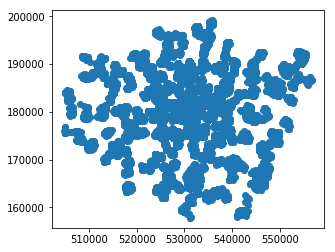

In [44]:
clustered_pois.plot()

## Save clusters

In [45]:
clustered_pois.to_csv(output_dir + 'pois_hdbscan_output.csv')
clustered_pois.to_pickle(output_dir + 'pois_hdbscan_output_gdf.pkl')

## Compute and visualize cluster borders

In [46]:
cluster_borders = clustered_pois.groupby(['label'], sort=False)['geometry'].agg([list, np.size])
geom = [shp.geometry.MultiPoint(x).convex_hull for x in cluster_borders['list']]
cluster_borders = GeoDataFrame(cluster_borders, crs=pois.crs, geometry=geom).drop(columns=['list'])

In [47]:
map_center = [51.507222, -0.1275] # London
m = folium.Map(location=map_center, zoom_start=12, tiles='OpenStreetMap', width=800, height=600)
folium.GeoJson(cluster_borders).add_to(m)
m